In [41]:
import cv2
import numpy as np

import time
import sys
import os

In [42]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

In [43]:
config_path="yolov3.cfg"
weights_path="yolov3.weights"
labels= open("coco.names").read().strip().split("\n")
colors=np.random.randint(0,255,size=(len(labels),3),dtype='uint8')

In [44]:
# load the YOLO network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [45]:
path_name="street.jpg"
image=cv2.imread(path_name)
file=os.path.basename(path_name)
filename,ext=file.split(".")
h,w=image.shape[:2]
blob= cv2.dnn.blobFromImage(image,1/255.0,(416,416),swapRB=True,crop=False)


In [46]:
print("image.shape:", image.shape)
print("blob.shape:", blob.shape)

image.shape: (1200, 1800, 3)
blob.shape: (1, 3, 416, 416)


In [47]:
net.setInput(blob)
ln=net.getLayerNames()
print(ln)
ln=[ln[i[0]-1] for i in net.getUnconnectedOutLayers()]
print(ln)

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [48]:
start = time.perf_counter()
layer_outputs = net.forward(ln)
time_took = time.perf_counter() - start
print(f"Time took: {time_took:.2f}s")

Time took: 2.29s


In [49]:
def generate_predictions(layer_outputs):
    CONFIDENCE=0.5
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores=detection[5:]
            class_id=np.argmax(scores)
            confidence=scores[class_id]

            if confidence>CONFIDENCE:
                box=detection[:4]*np.array([w,h,w,h])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return (boxes,class_ids,confidences)
                
    
            
            
            

In [50]:
predictions=generate_predictions(layer_outputs)


In [51]:
print(detection.shape)

(85,)


In [52]:
def draw_boxes(image,labels,predictions):
    boxes,class_ids,confidences=predictions
    for i in range(len(boxes)):
        x,y=boxes[i][0], boxes[i][1]
        w,h=boxes[i][2], boxes[i][3]

        color=[int(c) for c in colors[class_ids[i]]]
        cv2.rectangle(image,(x,y),(x+w,y+h),color=color,thickness=1)

        text= f" {labels[class_ids[i]]}: {confidences[i]:.2f}"

        text_width,text_height=cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX,fontScale=1 ,thickness=1)[0]
        text_offset_x = x
        text_offset_y = y - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
        overlay = image.copy()
        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)   
        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
        # now put the text (label: confidence %)
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(0, 0, 0), thickness=1)
    return image
    
    

In [53]:
Final_Image_without_iou=draw_boxes(image,labels,predictions)

cv2.imwrite(filename + "_yolo3." + ext, image)

True

In [54]:
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5


In [55]:
boxes,class_ids,confidences=predictions
# perform the non maximum suppression given the scores defined before
idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)

In [56]:
predictions=(boxes,class_ids,confidences,idxs)
def draw_boxes_iou(image,labels,predictions):
    
    boxes,class_ids,confidences,idxs=predictions
    if len(idxs)>0:
        
        for i in idxs.flatten():
            x,y=boxes[i][0], boxes[i][1]
            w,h=boxes[i][2], boxes[i][3]

            color=[int(c) for c in colors[class_ids[i]]]
            cv2.rectangle(image,(x,y),(x+w,y+h),color=color,thickness=1)

            text= f" {labels[class_ids[i]]}: {confidences[i]:.2f}"

            text_width,text_height=cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX,fontScale=1 ,thickness=1)[0]
            text_offset_x = x
            text_offset_y = y - 5
            box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
            overlay = image.copy()
            cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)   
            image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
            # now put the text (label: confidence %)
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1, color=(0, 0, 0), thickness=1)
        return image
    
    

        

In [57]:
Final_Image=draw_boxes_iou(image,labels,predictions)
cv2.imwrite(filename + "_yolo3_iou." + ext, image)

True

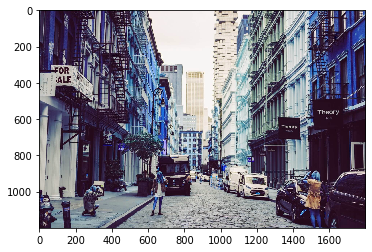

In [63]:
import matplotlib.pyplot as plt
plt.imshow(image)




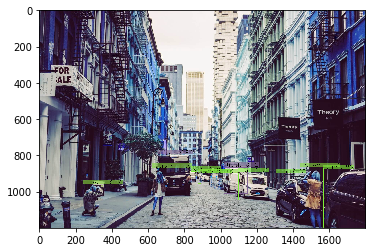

In [64]:
plt.imshow(Final_Image_without_iou)


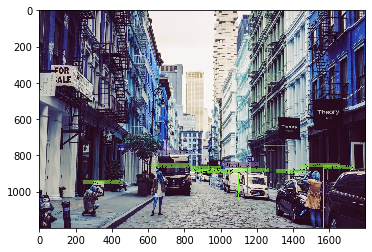

In [65]:
plt.imshow(Final_Image)